# Validation Service Benchmarks


In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from pprint import pprint

### Configuration

In [123]:
nmon_metric_options = [
    ("timestamp", "Timestamp MS since Epoch", [0, 80], "timestamp"), #0
    ("CPU_ALL:User%", "CPU Total: User %", [0,100], "cpu_all_user_percent"), # 1
    ("CPU_ALL:Sys%", "CPU Total: System %", [0,100], "cpu_all_system_percent"), # 2
    ("MEM:memtotal", "Memory MB: Total", [0,65000], "mem_MB_total"), #3
    ("MEM:hightotal", "Memory MB: High Total", [0,65000], "mem_MB_high_total"), #4
    ("MEM:lowtotal", "Memory MB: Low Total", [0,65000], "mem_MB_low_total"), #5
    ("MEM:swapfree", "Memory MB: Swap Free", [0,1000], "mem_MB_swap_free"), #6
    ("MEM:active", "Memory MB: Active", [0,65000], "mem_MB_active"), #7
    ("MEM:inactive", "Memory MB: Inactive", [0,65000], "mem_MB_inactive"), #8
    ("NET:eno1-write-KB/s", "Network Write KB/s", [0,1000], "net_io_write_KBps"), #9
    ("NET:eno1-read-KB/s", "Network Read KB/s", [0,1000], "net_io_read_KBps"), #10
    ("DISKBUSY:sda", "Disk Busy %: /dev/sda", [0,100], "disk_io_busy_percent"), #11
    ("DISKREAD:sda", "Disk Read KB/s: /dev/sda", [0,10000], "disk_io_read_KBps"), #12
    ("DISKWRITE:sda", "Disk Write KB/s: /dev/sda", [0,10000], "disk_io_write_KBps"), #13
    ("VM:pgfault", "Paging and Virtual Memory: Page Faults", [0,100], "virt_mem_page_faults") #14
]

free_mem_metrics = [
    ("total", "Memory Total", [0,67000], "mem_total_MB"), # 0
    ("used", "Memory Used", [0,67000], "mem_used_MB"), # 1
    ("free", "Memory Free", [0,67000], "mem_free_MB"), #2
    ("shared", "Memory Shared", [0,67000], "mem_shared_MB"), #3
    ("buff/cache", "Memory Buffer/Cache", [0,67000], "buff_cache_MB"), # 4
    ("available", "Memory Available", [0,67000], "mem_available_MB") # 5
]

possible_experiments = [
    "static_budget/no_budget/read_primary_shard",
    "static_budget/no_budget/read_local_mongod",
    "static_budget/sample_rate/10_percent/read_local_mongod",
    "static_budget/sample_rate/20_percent/read_local_mongod",
    "static_budget/sample_rate/50_percent/read_local_mongod",
    "static_budget/total_limit/20M/read_local_mongod"
]

experiments = [
    # "tensorflow/neural_network/no_budgets/job_mode_multiprocessing",
    # "tensorflow/neural_network/static_budgets/total_limit/10M",
    # "tensorflow/neural_network/static_budgets/sample_rate/20_percent",
    # "tensorflow/neural_network/no_budgets/job_mode_multiprocessing",
    "tensorflow/neural_network/no_budgets/job_mode_multiprocessing",
    "tensorflow/neural_network/variance_budgets/10M_total_500_initial"
]

chosen_metrics = [nmon_metric_options[10], nmon_metric_options[9], nmon_metric_options[12], nmon_metric_options[13]]
chosen_metric = nmon_metric_options[1]
metric_header = chosen_metric[0]
metric_name = chosen_metric[1]
y_axis_limits = chosen_metric[2]
metric_file_suffix = chosen_metric[3]

experiment_dfs = []  # net read
experiment_dfs_2 = [] # net write
experiment_dfs_3 = [] # disk read
experiment_dfs_4 = [] # disk write
for experiment in experiments:
    dataframes = []
    dataframes_2 = []
    dataframes_3 = []
    dataframes_4 = []
    for i in range(0, 25):
        machine_id = f"lattice-{150+i}"
        filename = f"{i}-{machine_id}.nmon.csv"
        #filename = f"{machine_id}_free.csv"
        filepath = f"{experiment}/{filename}"
        dataframe = pd.read_csv(filepath, header=0)
        dataframes.append(dataframe.pop(metric_header))
        # dataframes_2.append(dataframe.pop(chosen_metrics[1][0]))
        # dataframes_3.append(dataframe.pop(chosen_metrics[2][0]))
        # dataframes_4.append(dataframe.pop(chosen_metrics[3][0]))
    experiment_dfs.append((experiment, dataframes))
    # experiment_dfs_2.append((experiment, dataframes_2))
    # experiment_dfs_3.append((experiment, dataframes_3))
    # experiment_dfs_4.append((experiment, dataframes_4))

avg_worker_behavior_dfs = [] # worker net reads
avg_worker_behavior_dfs_2 = [] # worker net writes
avg_worker_behavior_dfs_3 = [] # worker disk reads
avg_worker_behavior_dfs_4 = [] # worker disk writes
master_behavior_dfs = []  # master net reads
master_behavior_dfs_2 = []  # master net writes
for experiment_path, machine_dfs in experiment_dfs:
    master_behavior_dfs.append(machine_dfs[0])
    df_concat0 = pd.concat(machine_dfs[1:22], axis=1)
    avg_worker_behavior_dfs.append((df_concat0.stack().groupby(level=[0,1]).mean().unstack()))

for experiment_path, machine_dfs in experiment_dfs_2:
    master_behavior_dfs_2.append(machine_dfs[0])
    df_concat0 = pd.concat(machine_dfs[1:22], axis=1)
    avg_worker_behavior_dfs_2.append((df_concat0.stack().groupby(level=[0,1]).mean().unstack()))

for experiment_path, machine_dfs in experiment_dfs_3:
    df_concat0 = pd.concat(machine_dfs[1:22], axis=1)
    avg_worker_behavior_dfs_3.append((df_concat0.stack().groupby(level=[0,1]).mean().unstack()))

for experiment_path, machine_dfs in experiment_dfs_4:
    df_concat0 = pd.concat(machine_dfs[1:22], axis=1)
    avg_worker_behavior_dfs_4.append((df_concat0.stack().groupby(level=[0,1]).mean().unstack()))

#pprint(avg_worker_behavior_dfs_2[1])

# number_rows = 1
# number_cols = 2
#
# fig, ax = plt.subplots(nrows=number_rows, ncols=number_cols, figsize=(10, 4))
# fig.tight_layout(h_pad=1.7)
# ax[0].plot(master_behavior_dfs[0]/1000, lw=1, label="Master Network Reads")
# ax[0].plot(master_behavior_dfs_2[0]/1000, lw=1, label="Master Network Writes")
# ax[0].plot(avg_worker_behavior_dfs[0]/1000, lw=1, label="Avg Worker Net Reads")
# ax[0].plot(avg_worker_behavior_dfs_2[0]/1000, lw=1, label="Avg Worker Net Writes")
# ax[0].plot(avg_worker_behavior_dfs_3[0]/1000, '--', lw=1, label="Avg Worker Disk Reads")
# ax[0].plot(avg_worker_behavior_dfs_4[0]/1000, '--', lw=1, label="Avg Worker Disk Writes")
# ax[0].legend()
# ax[0].set_title("No Budget")
# ax[0].set_ylabel("I/O MBps")
# ax[0].set_xlabel("Time into Job (sec)")
#
# ax[1].plot(master_behavior_dfs[1]/1000, lw=1, label="Master Network Reads")
# ax[1].plot(master_behavior_dfs_2[1]/1000, lw=1, label="Master Network Writes")
# ax[1].plot(avg_worker_behavior_dfs[1]/1000, lw=1, label="Avg Worker Net Reads")
# ax[1].plot(avg_worker_behavior_dfs_2[1]/1000, lw=1, label="Avg Worker Net Writes")
# ax[1].plot(avg_worker_behavior_dfs_3[1]/1000, '--', lw=1, label="Avg Worker Disk Reads")
# ax[1].plot(avg_worker_behavior_dfs_4[1]/1000, '--', lw=1, label="Avg Worker Disk Writes")
# ax[1].set_title("With Validation Budget")
# ax[1].set_xlabel("Time into Job (sec)")
# plt.savefig(f"{experiments[1]}/avg_worker_net_io_usage.png", dpi=300)

### Cluster Plotting

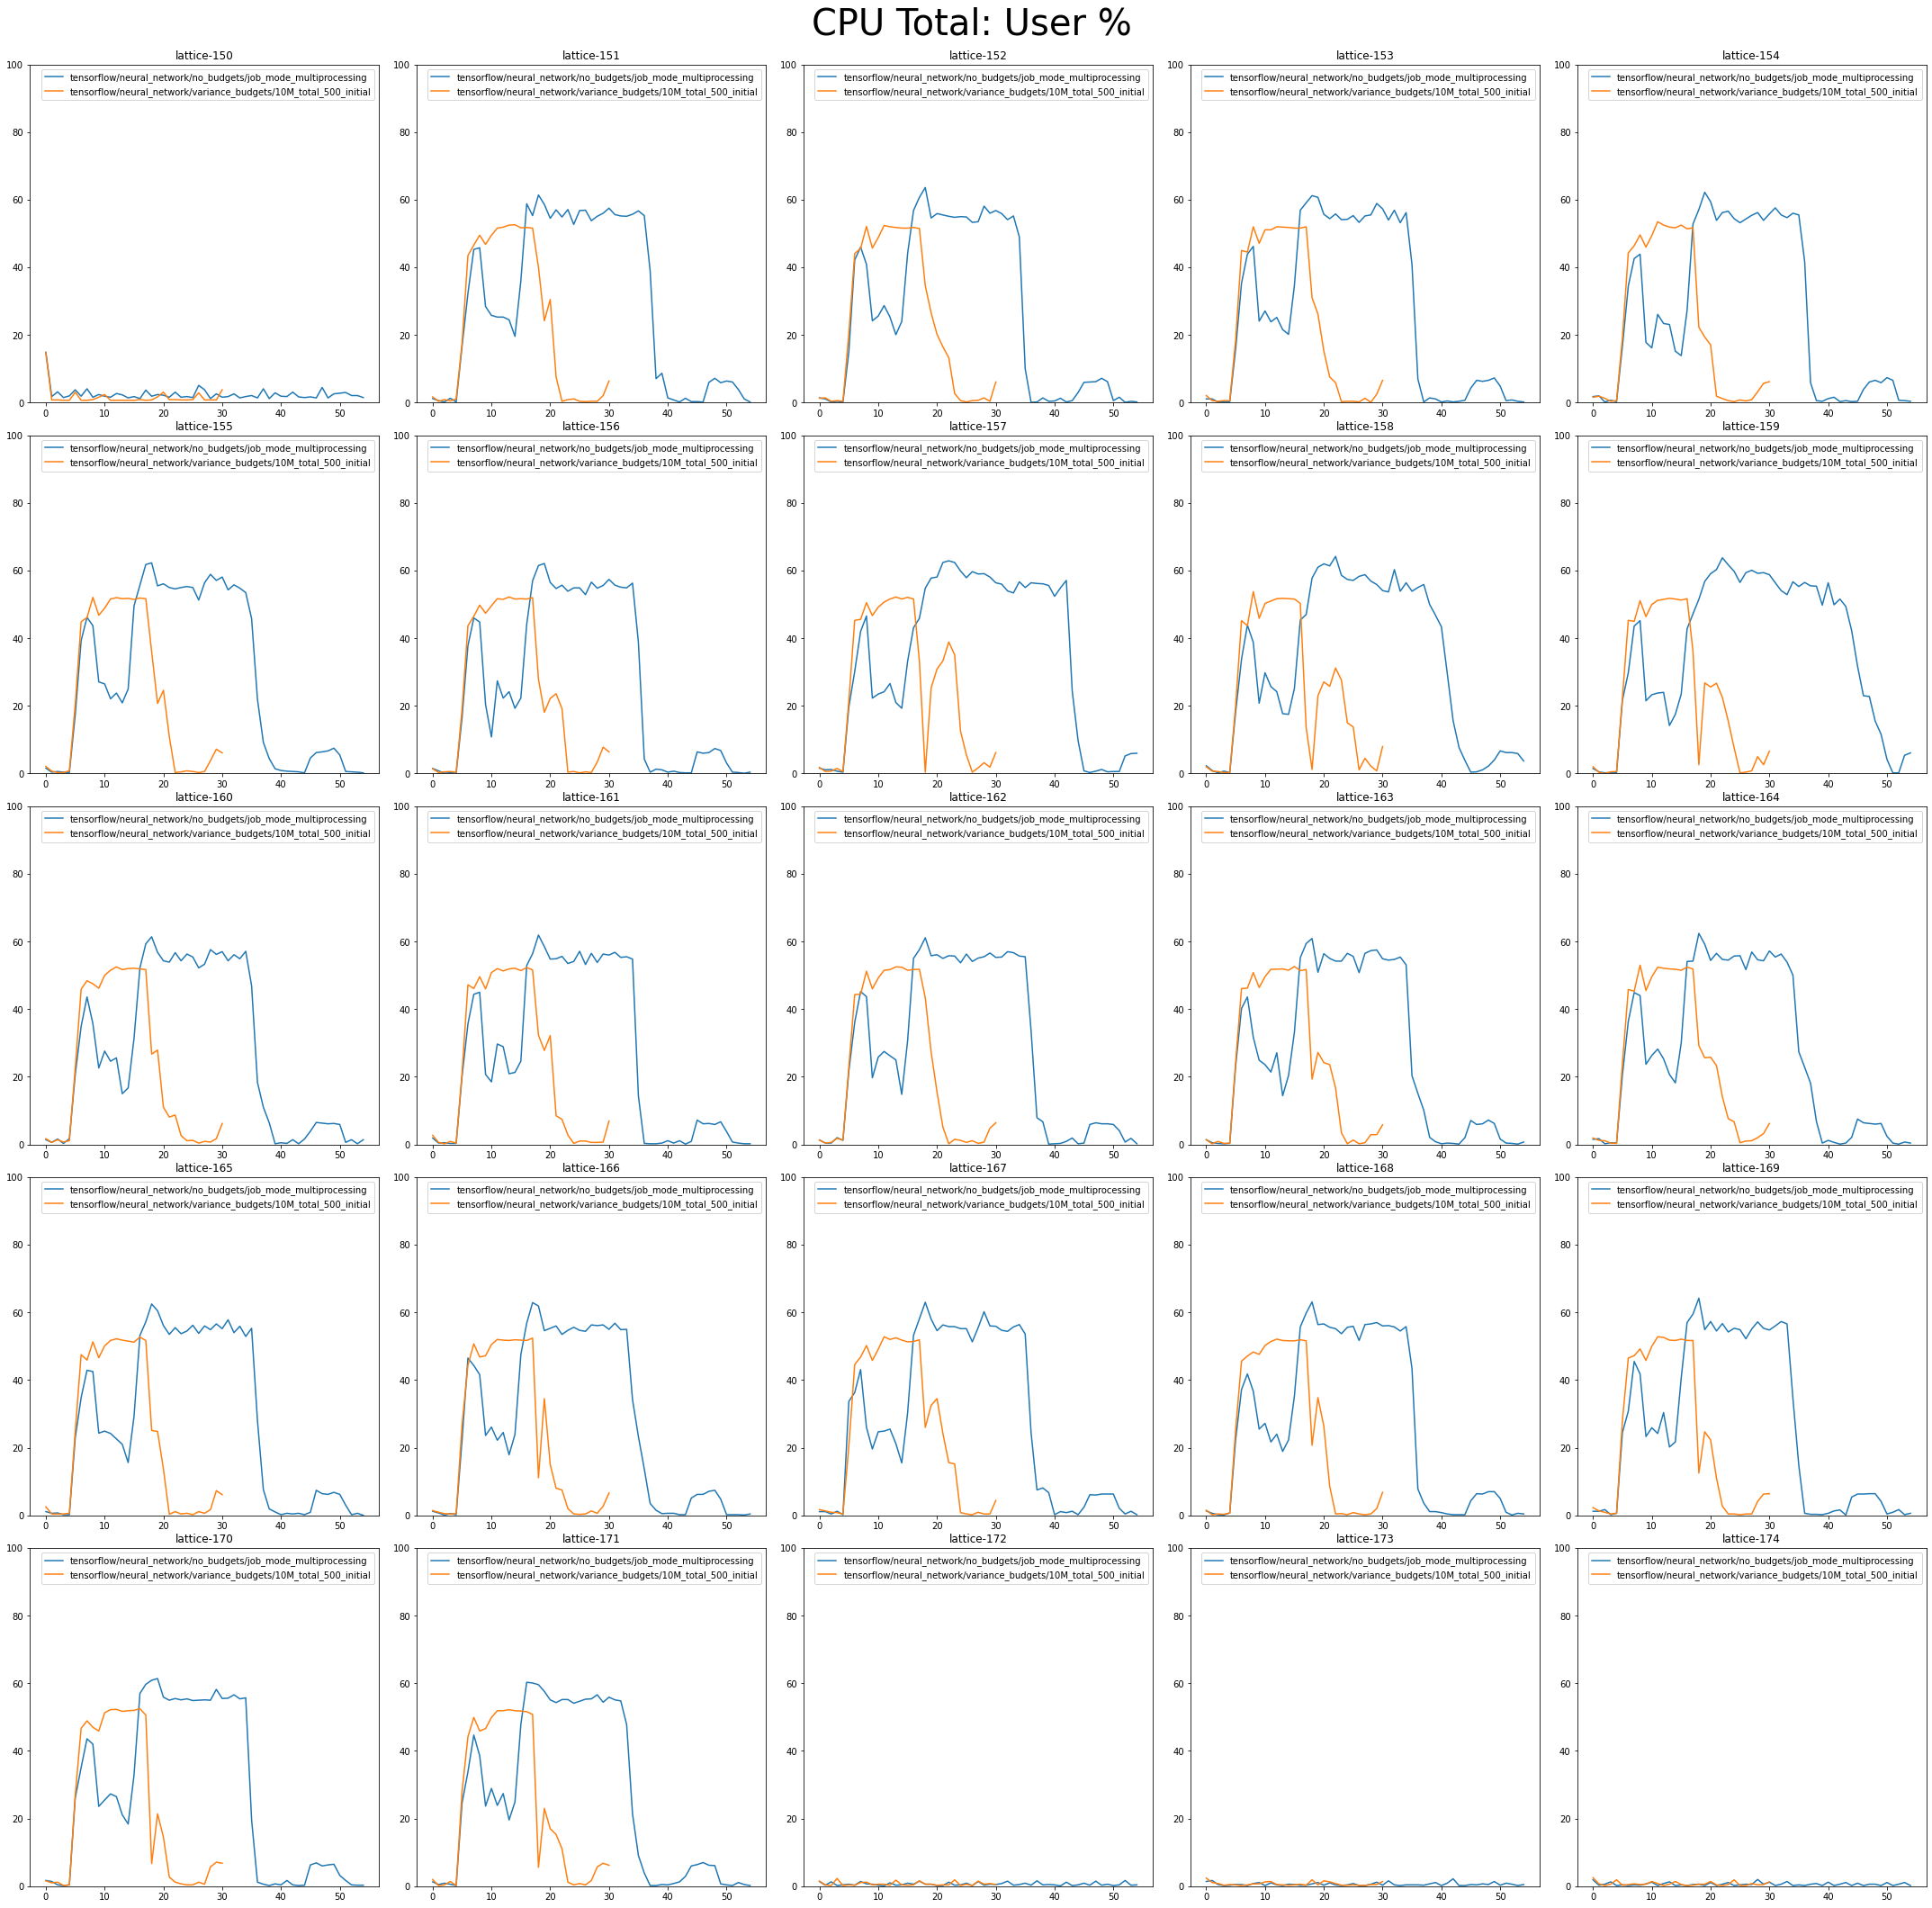

In [124]:
number_rows = 5
number_cols = 5

fig, ax = plt.subplots(nrows=number_rows, ncols=number_cols, figsize=(30, 30))
fig.tight_layout(h_pad=1.7)
fig.suptitle(metric_name, fontsize=40)

index = 0
for i in range(number_rows):
    for j in range(number_cols):
        for experiment, dataframe in experiment_dfs:
            ax[i,j].set_ylim(y_axis_limits)
            ax[i,j].plot(dataframe[index], label=experiment)
            ax[i,j].set_title(f"lattice-{150+index}")
            ax[i,j].legend()
        index += 1

plt.subplots_adjust(top=0.95)
plt.savefig(f"{experiments[0]}/cluster_statistics_{metric_file_suffix}.png", dpi=300)

### Response Plotting

Total response duration for tensorflow/neural_network/no_budgets/job_mode_multiprocessing: 45.424004406668246 seconds
Total response duration for tensorflow/neural_network/variance_budgets/10M_total_500_initial: 20.920863660998293 seconds


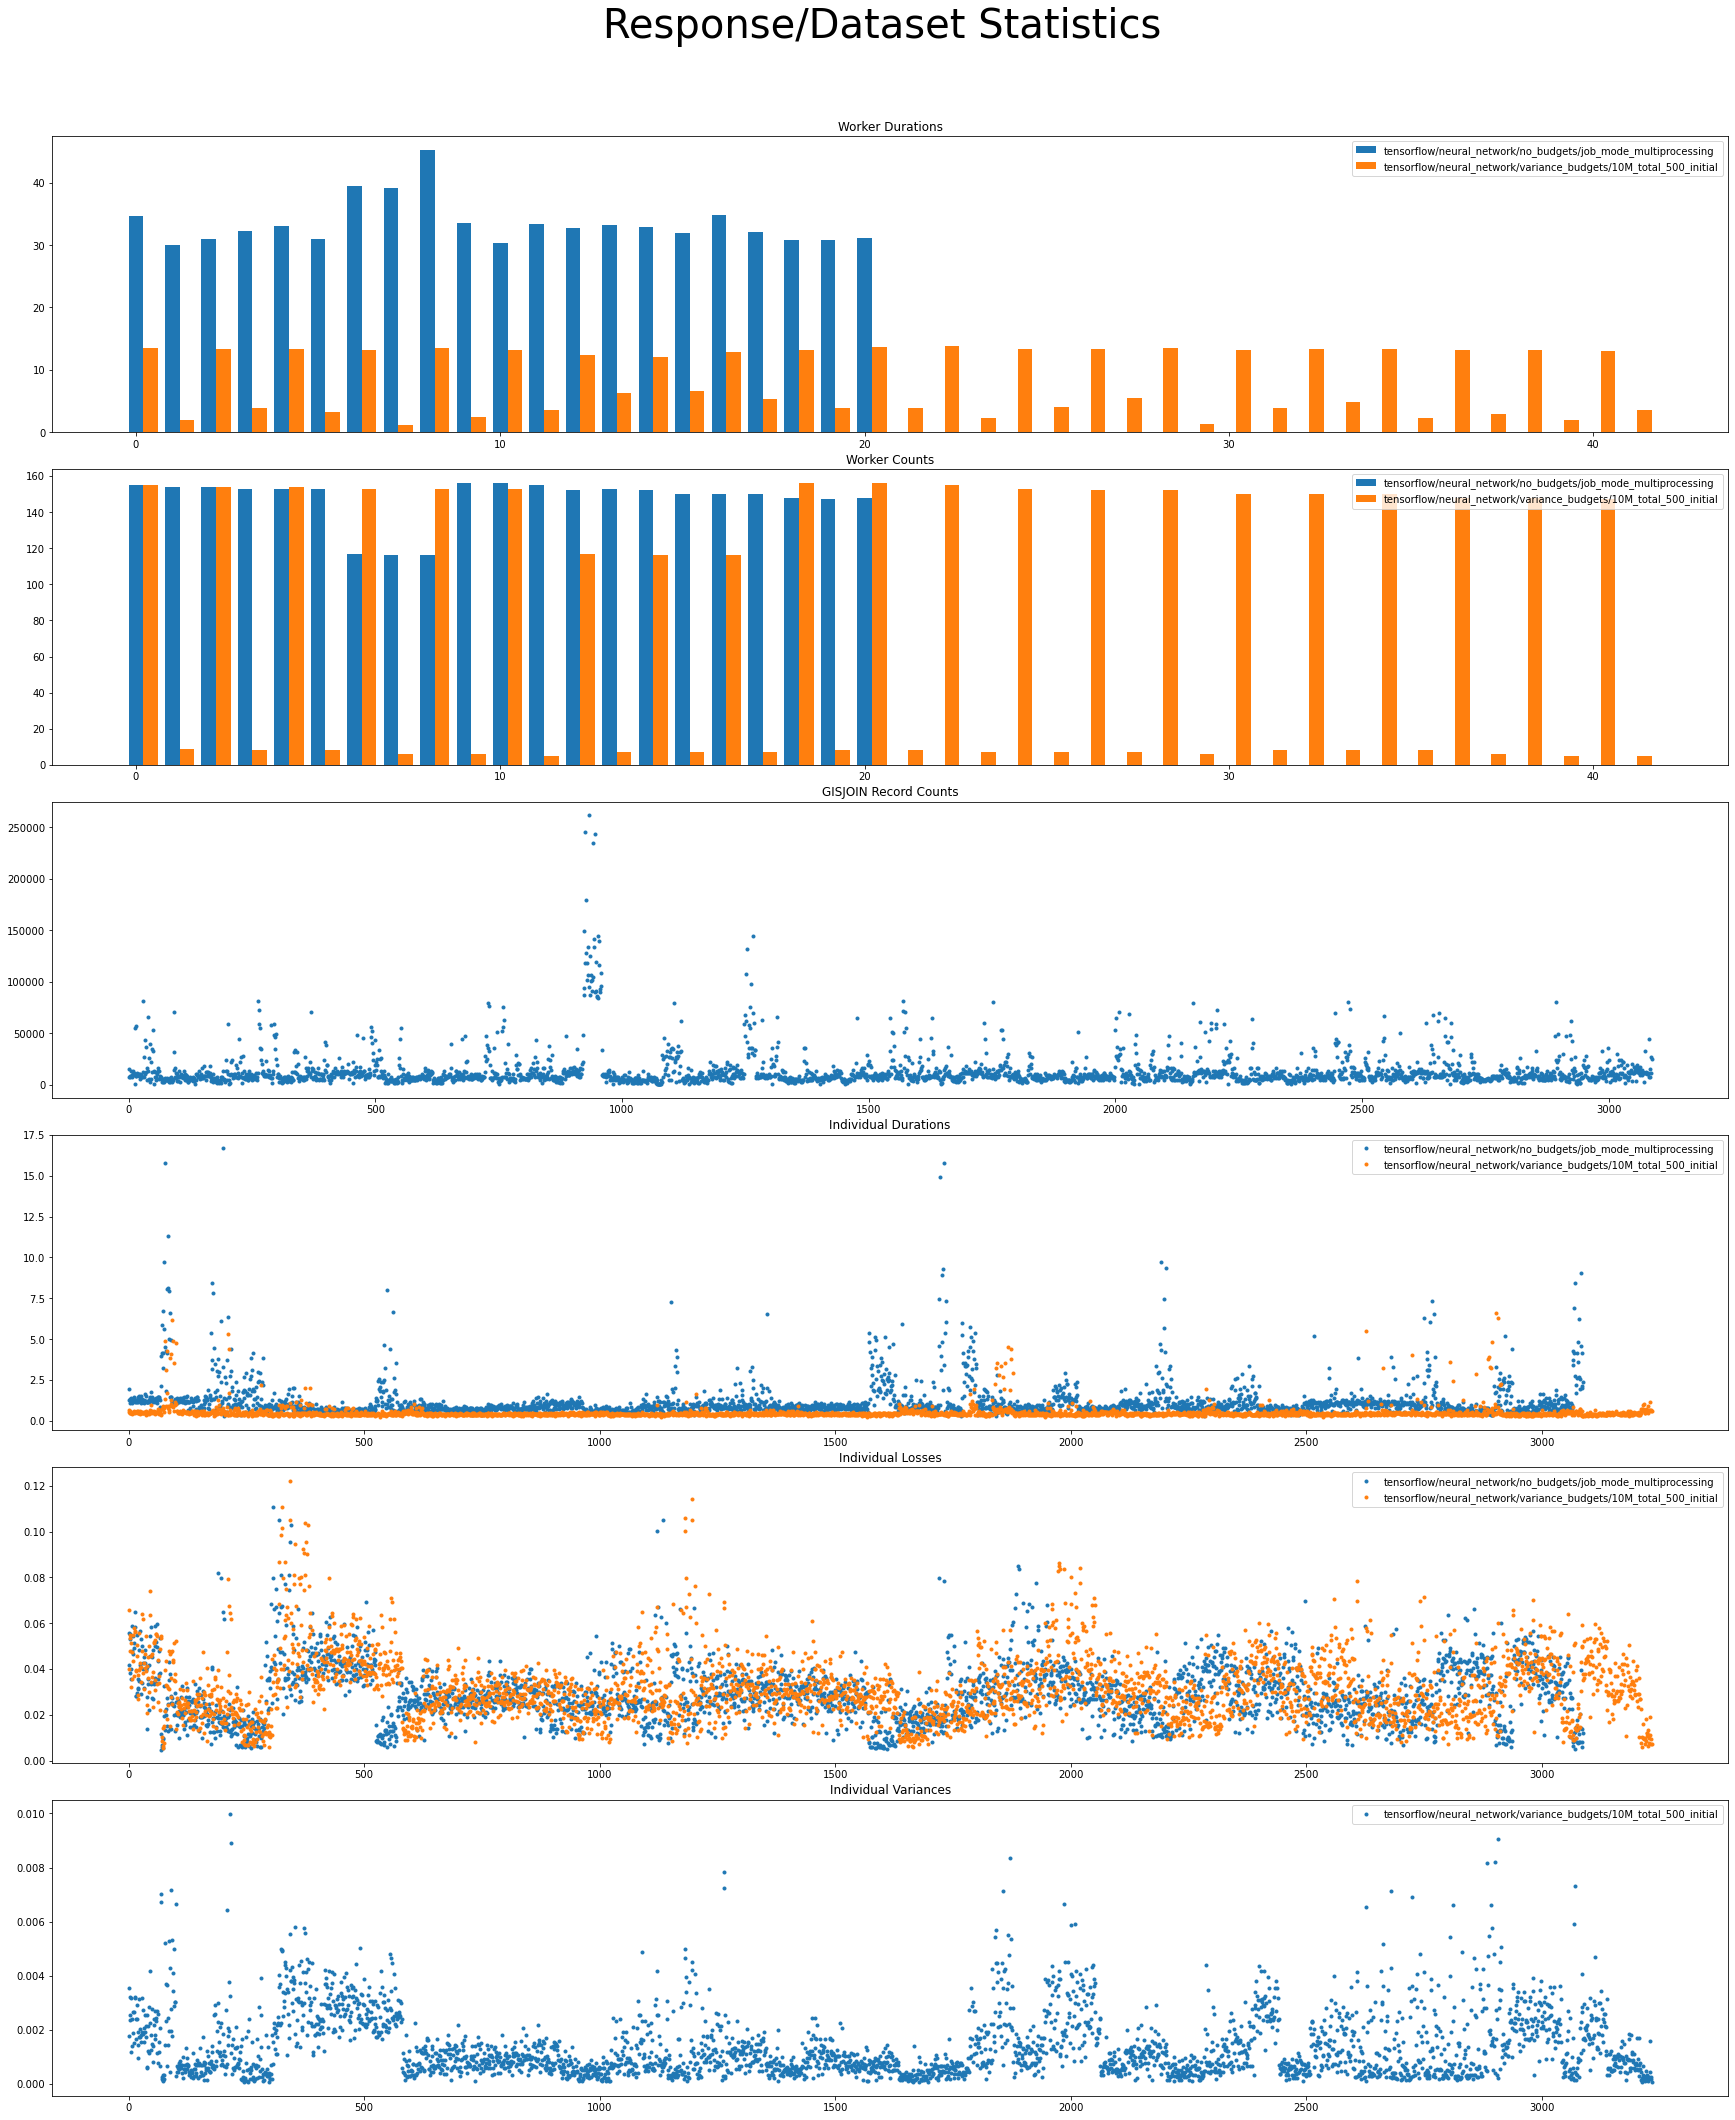

In [125]:
responses = []

for experiment in experiments:
    response_filename = f"{experiment}/response.json"
    with open(response_filename, "r") as response_file:
        responses.append((experiment, json.load(response_file)))

gis_join_count_filename = "../overlay/resources/gis_join_counts.json"

with open(gis_join_count_filename, "r") as f:
    gis_join_counts = json.load(f)

all_worker_counts = []
all_worker_durations = []
all_individual_durations = []
all_losses = []
all_variances = []

for experiment, response in responses:
    print(f"Total response duration for {experiment}: {response['duration_sec']} seconds")

    worker_durations = []
    worker_counts = []
    individual_durations = []
    individual_losses = []
    individual_variances = []
    for worker_response in response["worker_responses"]:
        worker_counts.append((worker_response["hostname"], len(worker_response["metrics"])))
        worker_durations.append((worker_response["hostname"], worker_response["duration_sec"]))
        for individual_metric in worker_response["metrics"]:
            if "duration_sec" in individual_metric.keys():
                individual_durations.append((individual_metric["gis_join"], individual_metric["duration_sec"]))
                individual_losses.append((individual_metric["gis_join"], individual_metric["loss"]))
                individual_variances.append((individual_metric["gis_join"], individual_metric["variance"]))

    individual_durations.sort(key=lambda y: y[0])
    all_individual_durations.append((experiment, [x[1] for x in individual_durations]))
    individual_losses.sort(key=lambda y: y[0])
    all_losses.append((experiment, [x[1] for x in individual_losses]))
    individual_variances.sort(key=lambda y: y[0])
    all_variances.append((experiment, [x[1] for x in individual_variances]))

    worker_durations.sort(key=lambda y: y[0])
    worker_durations_vals = [x[1] for x in worker_durations]
    worker_durations_names = [x[0][-3:] for x in worker_durations]
    all_worker_durations.append((experiment, worker_durations_names, worker_durations_vals))

    worker_counts.sort(key=lambda y: y[0])
    worker_counts_vals = [x[1] for x in worker_counts]
    worker_counts_names = [x[0][-3:] for x in worker_counts]
    all_worker_counts.append((experiment, worker_counts_names, worker_counts_vals))


# plt.figure(figsize=(10,4))
# worker_counts = all_worker_counts[0]
# plt.bar(np.arange(len(worker_counts[1])), worker_counts[2])
# plt.title("Worker Job Distribution")
# plt.ylabel("Assigned Spatial Extents")
# plt.xlabel("Worker Index")
# plt.savefig(f"{experiments[0]}/worker_distributions.png", dpi=300)

number_rows = 6
number_cols = 1

fig, ax = plt.subplots(nrows=number_rows, ncols=number_cols, figsize=(24, 30))
fig.tight_layout(h_pad=1.9)
fig.suptitle("Response/Dataset Statistics", fontsize=40)
bar_width = 1.0/len(experiments) - 0.1

idx = 0
for worker_durations in all_worker_durations:
    x_axis = np.arange(len(worker_durations[1]))
    ax[0].bar(x_axis + idx * bar_width, worker_durations[2], width=bar_width, label=worker_durations[0])
    idx += 1
ax[0].set_title(f"Worker Durations")
ax[0].legend(loc="upper right")

idx = 0
for worker_counts in all_worker_counts:
    x_axis = np.arange(len(worker_counts[1]))
    ax[1].bar(x_axis + idx * bar_width, worker_counts[2], width=bar_width, label=worker_counts[0])
    idx += 1
ax[1].set_title(f"Worker Counts")
ax[1].legend(loc="upper right")

ax[2].set_title(f"GISJOIN Record Counts")
counts = list(gis_join_counts.values())
ax[2].plot(counts, '.')

for individual_durations in all_individual_durations:
    ax[3].plot(individual_durations[1], '.', label=individual_durations[0])
ax[3].set_title(f"Individual Durations")
ax[3].legend(loc="upper right")

for individual_losses in all_losses:
    ax[4].plot(individual_losses[1], '.', label=individual_losses[0])
ax[4].set_title(f"Individual Losses")
ax[4].legend(loc="upper right")

#for individual_variances in all_variances:
individual_variances = all_variances[1]
ax[5].plot(individual_variances[1], '.', label=individual_variances[0])
ax[5].set_title(f"Individual Variances")
ax[5].legend(loc="upper right")

plt.subplots_adjust(top=0.92)

plt.savefig(f"{experiments[0]}/response_dataset_statistics.png", dpi=300)

### Variance Budget Experiments

gis_join=G0201000, initial_alloc=500, final_alloc=500
gis_join=G0500870, initial_alloc=500, final_alloc=500
gis_join=G0100250, initial_alloc=500, final_alloc=500
gis_join=G0100550, initial_alloc=500, final_alloc=500
gis_join=G0101290, initial_alloc=500, final_alloc=500
gis_join=G0500430, initial_alloc=500, final_alloc=500
gis_join=G0100310, initial_alloc=500, final_alloc=500
gis_join=G0500930, initial_alloc=500, final_alloc=500
gis_join=G0501230, initial_alloc=500, final_alloc=500
gis_join=G0500370, initial_alloc=500, final_alloc=500
gis_join=G0600530, initial_alloc=500, final_alloc=500
gis_join=G0800650, initial_alloc=500, final_alloc=500
gis_join=G0600830, initial_alloc=500, final_alloc=500
gis_join=G0800190, initial_alloc=500, final_alloc=500
gis_join=G0801050, initial_alloc=500, final_alloc=500
gis_join=G0600190, initial_alloc=500, final_alloc=500
gis_join=G0601070, initial_alloc=500, final_alloc=500
gis_join=G1000050, initial_alloc=500, final_alloc=500
gis_join=G1200030, initial_a

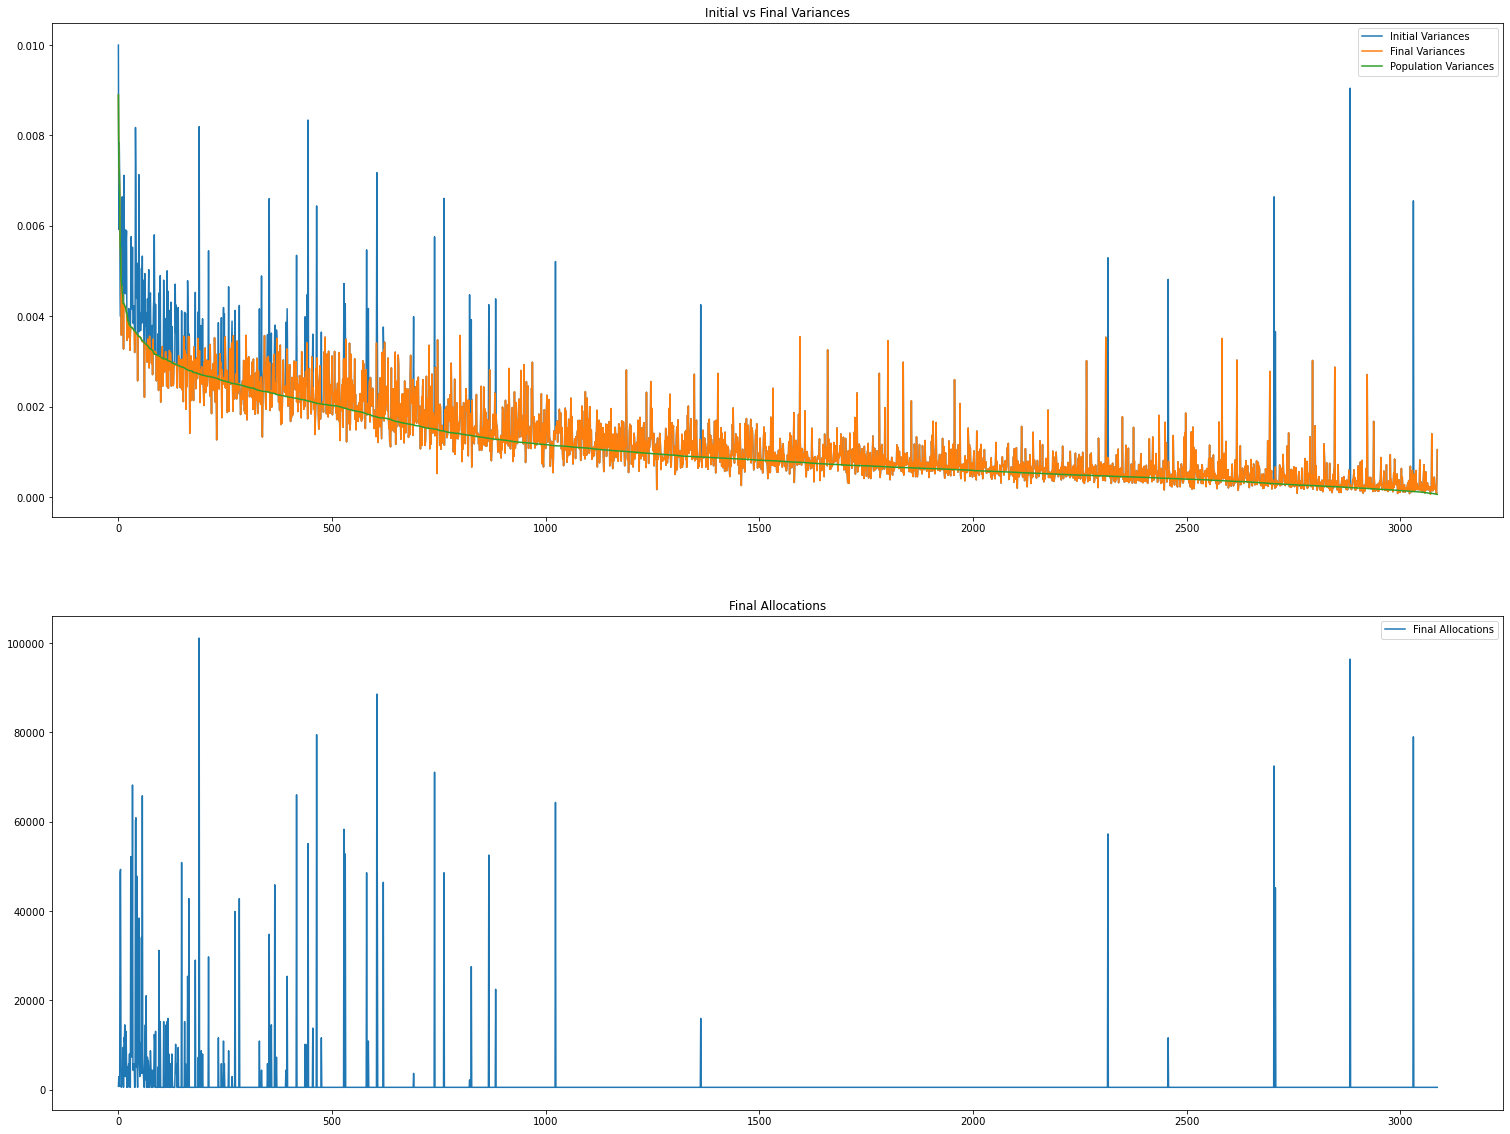

In [126]:
intermediate_response_filename = "tensorflow/neural_network/variance_budgets/10M_total_500_initial/intermediate_response.json"
final_response_filename = "tensorflow/neural_network/variance_budgets/10M_total_500_initial/response.json"
no_budget_response_filename = "tensorflow/neural_network/no_budgets/job_mode_multiprocessing/response.json"

with open(intermediate_response_filename, "r") as f:
    intermediate_data = json.load(f)

with open(final_response_filename, "r") as f:
    final_data = json.load(f)

with open(no_budget_response_filename, "r") as f:
    no_budget_data = json.load(f)


gis_join_metrics = {}
for metric in intermediate_data["initial_response_metrics"]:
    if metric["allocation"] >= intermediate_data["initial_allocation"]:
        gis_join_metrics[metric["gis_join"]] = {
            "gis_join": metric["gis_join"],
            "initial_variance": metric["variance"],
            "initial_allocation": metric["allocation"],
            "initial_loss": metric["loss"],
            "final_variance": metric["variance"],
            "final_allocation": metric["allocation"],
            "final_loss": metric["loss"]
        }

for worker_response in final_data["worker_responses"]:
    for metric in worker_response["metrics"]:
        if metric["gis_join"] in gis_join_metrics:
            gis_join_metric = gis_join_metrics[metric["gis_join"]]
            gis_join_metric["final_variance"] = metric["variance"]
            gis_join_metric["final_allocation"] = metric["allocation"]
            gis_join_metric["final_loss"] = metric["loss"]

            if gis_join_metric["final_variance"] == gis_join_metric["initial_variance"]:
                print(f"gis_join={gis_join_metric['gis_join']}, initial_alloc={gis_join_metric['initial_allocation']}, final_alloc={gis_join_metric['final_allocation']}")

for worker_response in no_budget_data["worker_responses"]:
    for metric in worker_response["metrics"]:
        if metric["gis_join"] in gis_join_metrics:
            existing_metric = gis_join_metrics[metric["gis_join"]]
            existing_metric["population_variance"] = metric["variance"]
            existing_metric["population_allocation"] = metric["allocation"]
            existing_metric["population_loss"] = metric["loss"]

print(gis_join_metrics["G4800430"])

as_list = list(gis_join_metrics.values())
as_list.sort(key=lambda m: m["population_variance"], reverse=True)
#as_list = as_list[:250]

initial_variances = [m["initial_variance"] for m in as_list]
final_variances = [m["final_variance"] for m in as_list]
population_variances = [m["population_variance"] for m in as_list]

initial_losses = [m["initial_loss"] for m in as_list]
final_losses = [m["final_loss"] for m in as_list]
population_losses = [m["population_loss"] for m in as_list]

number_rows = 2
number_cols = 1

fig, ax = plt.subplots(nrows=number_rows, ncols=number_cols, figsize=(26, 20))

# --- Plot variances ---
ax[0].plot(initial_variances, '-', ms=4, label="Initial Variances")
ax[0].plot(final_variances, '-', ms=4, label="Final Variances")
ax[0].plot(population_variances, '-', ms=4, label="Population Variances")

# --- Plot losses ---
#ax[0].plot(initial_losses, '-', ms=4, label="Initial Losses")
#ax[0].plot(final_losses, '-', ms=4, label="Final Losses")
#ax[0].plot(population_losses, '-', ms=4, label="Population Losses")

#ax[0].plot(initial_losses, final_losses, '.', label="Losses")

ax[0].set_title("Initial vs Final Variances")
#ax[0].plot(sorted([x[3] for x in no_budget_metrics], reverse=True), label="No Budget Variances")
#ax[0].plot([x[3] for x in sorted_pop_losses], '.', label="No Budget Losses")
#ax[0].axhline(y=0.001169725909715914, color='r', linestyle='-')
ax[0].legend()
ax[1].set_title("Final Allocations")
ax[1].plot([int(m["final_allocation"]) for m in as_list], '-', label="Final Allocations")
ax[1].legend()

plt.show()

varying_losses = []
for metric in as_list:
    #print(f"GISJOIN: {metric['gis_join']}, Difference: {abs(metric['initial_loss'] - metric['final_loss'])}")
    varying_losses.append((metric["gis_join"], abs(metric['initial_loss'] - metric['final_loss'])))

varying_losses.sort(key=lambda y: y[1], reverse=True)

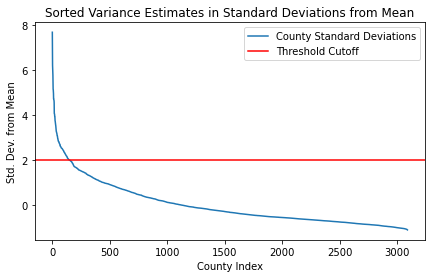

In [127]:
with open("tensorflow/neural_network/variance_budgets/10M_total_500_initial/numpy_array.json", "r") as f:
    std_devs = json.load(f)

plt.figure(figsize=(7,4))
plt.plot(std_devs, label="County Standard Deviations")
plt.axhline(y=2, color='r', label="Threshold Cutoff")
plt.ylabel("Std. Dev. from Mean")
plt.xlabel("County Index")
plt.legend()
plt.title("Sorted Variance Estimates in Standard Deviations from Mean")
plt.savefig("tensorflow/neural_network/variance_budgets/10M_total_500_initial/variance_std_devs_threshold.png", dpi=300)
#plt.show()

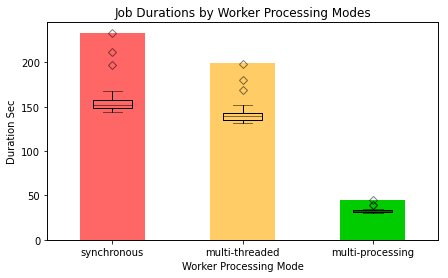

In [128]:
with open("tensorflow/neural_network/no_budgets/job_mode_multiprocessing/response.json", "r") as f:
    multiprocessing = json.load(f)

with open("tensorflow/neural_network/no_budgets/job_mode_multithreaded/response.json", "r") as f:
    multithreaded = json.load(f)

with open("tensorflow/neural_network/no_budgets/job_mode_synchronous/response.json", "r") as f:
    synchronous = json.load(f)

multiprocessing_workers = [x["duration_sec"] for x in multiprocessing["worker_responses"]]
multithreaded_workers = [x["duration_sec"] for x in multithreaded["worker_responses"]]
synchronous_workers = [x["duration_sec"] for x in synchronous["worker_responses"]]

fig, ax1 = plt.subplots(figsize=(7,4))
ax1.bar([1,2,3], [synchronous["duration_sec"], multithreaded["duration_sec"], multiprocessing["duration_sec"]], width=0.5, color=['#ff6666', '#ffcc66', '#00cc00'])
ax2 = ax1.twinx()
bp = ax1.boxplot([synchronous_workers, multithreaded_workers, multiprocessing_workers], patch_artist=False)

# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='k',
            linewidth = 1,
            alpha = 0.5)
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='k',
               linewidth = 1,
               alpha = 0.5)
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='k',
              alpha = 0.5)



ax1.set_xticklabels(["synchronous", "multi-threaded", "multi-processing"])
ax2.set_yticks([])

ax1.set_ylabel("Duration Sec")
ax1.set_xlabel("Worker Processing Mode")
plt.title("Job Durations by Worker Processing Modes")
plt.savefig("tensorflow/neural_network/no_budgets/processing_mode_durations.png", dpi=300)